In [21]:
# CÉLULA 1 - Cabeçalho e imports
# ---------------------------------------------------------
# Etapa 4: Otimização e Tuning de Hiperparâmetros
# Notebook: notebooks/04_Otimizacao.ipynb
# Objetivo: executar Grid/Random search, treinar modelo final, avaliar em teste e salvar modelo.
# ---------------------------------------------------------

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import time
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (9,6)

# Tentar importar xgboost (opcional)
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except Exception:
    XGBOOST_AVAILABLE = False


In [22]:
# CÉLULA 2 - Recapitulação (carregar baseline salvo e resultados da etapa 3)
# ---------------------------------------------------------
# Se você salvou o modelo baseline e a lista de features na Etapa 3,
# carregue-os aqui para comparar "antes vs depois".
# ---------------------------------------------------------

# caminhos (ajuste se necessário)
BASELINE_MODEL_PATH = "modelo_regressao_linear.pkl"   # do seu código da Etapa 3
FEATURES_JSON_PATH = "lista_features.json"
CLEAN_CSV_PATH = "youtube_views_clean.csv"  # arquivo que você gerou na Etapa 2

# Carregar baseline (se existir)
baseline_exists = os.path.exists(BASELINE_MODEL_PATH)
if baseline_exists:
    baseline_model = joblib.load(BASELINE_MODEL_PATH)
    print("✓ Baseline carregado:", BASELINE_MODEL_PATH)
else:
    baseline_model = None
    print("⚠️ Baseline NÃO encontrado em", BASELINE_MODEL_PATH)

# Carregar features (se existir)
if os.path.exists(FEATURES_JSON_PATH):
    with open(FEATURES_JSON_PATH, "r") as f:
        baseline_features = json.load(f)
    print("✓ Lista de features carregada:", FEATURES_JSON_PATH)
else:
    baseline_features = None
    print("⚠️ Features JSON NÃO encontrado:", FEATURES_JSON_PATH)

# Carregar dados limpos (dataset da Etapa 2)
df = pd.read_csv(CLEAN_CSV_PATH)
print(f"✓ Dados carregados: {df.shape[0]} linhas, {df.shape[1]} colunas")


✓ Baseline carregado: modelo_regressao_linear.pkl
✓ Lista de features carregada: lista_features.json
✓ Dados carregados: 2520 linhas, 25 colunas


In [23]:
# CÉLULA 3 - Preparação de X e y (usar o mesmo target da Etapa 3)
# ---------------------------------------------------------
# No seu código da Etapa 3 você usou 'total_views_log' como target.
# Vamos reproduzir a mesma separação.
# ---------------------------------------------------------
TARGET = 'total_views_log'  # confirme que a coluna existe no df

if TARGET not in df.columns:
    raise ValueError(f"Coluna target '{TARGET}' não encontrada no dataframe. Verifique o arquivo '{CLEAN_CSV_PATH}'")

# Lista de colunas para remover (se houver)
COLUNAS_REMOVER = []  # você afirmou que não tem ID, então vazio

# Selecionar X e y
X = df.drop(columns=[TARGET] + COLUNAS_REMOVER, errors='ignore')
y = df[TARGET].copy()

# Manter apenas colunas numéricas para modelos que exigem numéricas
X_numeric = X.select_dtypes(include=[np.number]).copy()

print("Features numéricas disponíveis:", X_numeric.shape[1])
print(X_numeric.columns.tolist())


Features numéricas disponíveis: 15
['duration_minutes', 'title_length', 'description_length', 'tags_count', 'channel_subscribers', 'channel_age_months', 'previous_videos_count', 'avg_upload_frequency_days', 'comments_count', 'likes_count', 'shares_count', 'playlist_adds', 'total_views', 'engagement_rate', 'views_per_tag']


In [24]:
# CÉLULA 4 - Divisão em TREINO / VALIDAÇÃO / TESTE (60/20/20) - com random_state
# ---------------------------------------------------------
RANDOM_STATE = 42

# Primeiro separar 20% para teste
X_temp, X_test, y_temp, y_test = train_test_split(
    X_numeric, y, test_size=0.2, random_state=RANDOM_STATE
)

# Separar validação de 20% do total (25% do temp)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE
)

print("Divisão feita:")
print(f"  Treino:     {len(X_train)}")
print(f"  Validação:  {len(X_val)}")
print(f"  Teste:      {len(X_test)}")

# Estatísticas do target
print("\nDistribuição do target:")
print(f"Treino: mean={y_train.mean():.4f}, std={y_train.std():.4f}")
print(f"Validação: mean={y_val.mean():.4f}, std={y_val.std():.4f}")
print(f"Teste: mean={y_test.mean():.4f}, std={y_test.std():.4f}")


Divisão feita:
  Treino:     1512
  Validação:  504
  Teste:      504

Distribuição do target:
Treino: mean=13.4106, std=0.7533
Validação: mean=13.3890, std=0.7397
Teste: mean=13.3511, std=0.6969


In [25]:
# CÉLULA 5 - Funções utilitárias (métricas, salvar resultados)
# ---------------------------------------------------------
def calcular_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}

def print_metricas(dic, nome=""):
    print(f"\nMétricas - {nome}")
    for k, v in dic.items():
        print(f"  {k}: {v:.4f}")


In [26]:
# CÉLULA 6 - Baseline quick-eval (se baseline_model estiver disponível)
# ---------------------------------------------------------
if baseline_model is not None and baseline_features is not None:
    # Garantir que X_test tem as mesmas colunas do baseline
    X_test_b = X_test.reindex(columns=baseline_features, fill_value=0)

    # --- CORREÇÃO DOS VALORES FALTANTES AQUI ---
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='median')
    X_test_b = pd.DataFrame(imputer.fit_transform(X_test_b), columns=X_test_b.columns)
    # --------------------------------------------

    # Predição do baseline
    y_pred_baseline = baseline_model.predict(X_test_b)
    metricas_baseline = calcular_metricas(y_test, y_pred_baseline)

    print("✓ Métricas Baseline (usando modelo salvo da Etapa 3):")
    print_metricas(metricas_baseline, "Baseline (Etapa 3)")

else:
    print("Ignorando avaliação do baseline (arquivo não encontrado).")


✓ Métricas Baseline (usando modelo salvo da Etapa 3):

Métricas - Baseline (Etapa 3)
  MSE: 0.0381
  RMSE: 0.1952
  MAE: 0.1268
  R2: 0.9214


In [27]:
# CÉLULA 7 - Setup: Pipeline padrão (Scaler + Estimador)
# ---------------------------------------------------------
# Usaremos pipelines para garantir que o scaler é aplicado apenas ao treino durante CV.
def make_pipeline(estimator):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("model", estimator)
    ])


In [28]:
# CÉLULA EXTRA - Imputação antes dos modelos lineares
# --------------------------------------------------------

from sklearn.impute import SimpleImputer

# Imputar valores faltantes com mediana (melhor para modelos lineares)
imputer = SimpleImputer(strategy='median')

# Ajusta o imputer no X_train e transforma ambos
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

print("✓ Imputação concluída. Nenhum NaN restante no X_train/X_test:")
print("NaN X_train:", X_train.isna().sum().sum())
print("NaN X_test:", X_test.isna().sum().sum())


✓ Imputação concluída. Nenhum NaN restante no X_train/X_test:
NaN X_train: 0
NaN X_test: 0


In [29]:
# CÉLULA 8 - GridSearch para modelos lineares regularizados (Ridge, Lasso, ElasticNet)
# ---------------------------------------------------------
# Esses modelos regulam a regressão linear e costumam melhorar baseline linear simples.
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Ridge
ridge_pipe = make_pipeline(Ridge())
ridge_param_grid = {
    "model__alpha": [1e-3, 1e-2, 1e-1, 0.5, 1.0, 5.0, 10.0, 50.0]
}
ridge_gs = GridSearchCV(ridge_pipe, ridge_param_grid, cv=cv, scoring="r2", n_jobs=-1, verbose=1)

# Lasso
lasso_pipe = make_pipeline(Lasso(max_iter=5000))
lasso_param_grid = {
    "model__alpha": [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1.0]
}
lasso_gs = GridSearchCV(lasso_pipe, lasso_param_grid, cv=cv, scoring="r2", n_jobs=-1, verbose=1)

# ElasticNet
en_pipe = make_pipeline(ElasticNet(max_iter=5000))
en_param_grid = {
    "model__alpha": [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1.0],
    "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
}
en_gs = GridSearchCV(en_pipe, en_param_grid, cv=cv, scoring="r2", n_jobs=-1, verbose=1)

# Executar (pode demorar alguns minutos)
print("GridSearch Ridge...")
t0 = time.time(); ridge_gs.fit(X_train, y_train); print("done in", time.time()-t0)
print("GridSearch Lasso...")
t0 = time.time(); lasso_gs.fit(X_train, y_train); print("done in", time.time()-t0)
print("GridSearch ElasticNet...")
t0 = time.time(); en_gs.fit(X_train, y_train); print("done in", time.time()-t0)

# Coletar melhores
best_linears = {
    "Ridge": {"best_estimator": ridge_gs.best_estimator_, "best_params": ridge_gs.best_params_, "best_score": ridge_gs.best_score_},
    "Lasso": {"best_estimator": lasso_gs.best_estimator_, "best_params": lasso_gs.best_params_, "best_score": lasso_gs.best_score_},
    "ElasticNet": {"best_estimator": en_gs.best_estimator_, "best_params": en_gs.best_params_, "best_score": en_gs.best_score_},
}
for name, info in best_linears.items():
    print(f"\n{name} -> best R2 (CV): {info['best_score']:.4f} params: {info['best_params']}")


GridSearch Ridge...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
done in 0.11025476455688477
GridSearch Lasso...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
done in 0.0644381046295166
GridSearch ElasticNet...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
done in 0.33538103103637695

Ridge -> best R2 (CV): 0.9178 params: {'model__alpha': 5.0}

Lasso -> best R2 (CV): 0.9185 params: {'model__alpha': 0.01}

ElasticNet -> best R2 (CV): 0.9186 params: {'model__alpha': 0.01, 'model__l1_ratio': 0.7}


In [30]:
# CÉLULA 9 - RandomizedSearchCV para RandomForest (tuning mais pesado, mas importante)
# ---------------------------------------------------------
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

rf = RandomForestRegressor(random_state=RANDOM_STATE)

rf_param_dist = {
    "model__n_estimators": [100, 200, 400],
    "model__max_depth": [None, 6, 10, 20],
    "model__min_samples_split": sp_randint(2, 10),
    "model__min_samples_leaf": sp_randint(1, 6),
    "model__max_features": ["auto", "sqrt", 0.6, 0.8]
}

rf_pipe = make_pipeline(rf)

rf_random = RandomizedSearchCV(
    rf_pipe,
    param_distributions=rf_param_dist,
    n_iter=30,  # ajuste conforme seu tempo
    cv=cv,
    scoring="r2",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

print("RandomizedSearch RandomForest...")
t0 = time.time(); rf_random.fit(X_train, y_train); print("done in", time.time()-t0)
print("RandomForest best score (CV):", rf_random.best_score_)
print("RandomForest best params:", rf_random.best_params_)


RandomizedSearch RandomForest...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
done in 25.408279418945312
RandomForest best score (CV): 0.9996123153779027
RandomForest best params: {'model__max_depth': None, 'model__max_features': 0.8, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 100}


In [31]:
# CÉLULA 10 - (Opcional) Tuning XGBoost se disponível
# ---------------------------------------------------------
if XGBOOST_AVAILABLE:
    print("XGBoost disponível -> executando RandomizedSearch")
    xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE, verbosity=0)
    xgb_param_dist = {
        "model__n_estimators": [100, 200, 400],
        "model__max_depth": [3, 5, 7, 10],
        "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
        "model__subsample": [0.6, 0.8, 1.0],
        "model__colsample_bytree": [0.6, 0.8, 1.0],
        "model__reg_alpha": [0, 0.01, 0.1, 1],
        "model__reg_lambda": [1, 1.5, 2.0]
    }
    xgb_pipe = make_pipeline(xgb_reg)
    xgb_random = RandomizedSearchCV(xgb_pipe, param_distributions=xgb_param_dist, n_iter=30, cv=cv, scoring="r2", n_jobs=-1, random_state=RANDOM_STATE, verbose=1)
    t0 = time.time(); xgb_random.fit(X_train, y_train); print("done in", time.time()-t0)
    print("XGBoost best score (CV):", xgb_random.best_score_)
    print("XGBoost best params:", xgb_random.best_params_)
else:
    print("XGBoost NÃO disponível: pule essa etapa ou instale (pip install xgboost)")


XGBoost disponível -> executando RandomizedSearch
Fitting 5 folds for each of 30 candidates, totalling 150 fits
done in 21.592784643173218
XGBoost best score (CV): 0.9997367234817134
XGBoost best params: {'model__subsample': 0.8, 'model__reg_lambda': 1, 'model__reg_alpha': 0.1, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__learning_rate': 0.1, 'model__colsample_bytree': 1.0}


In [32]:
# CÉLULA 11 - Análise dos resultados do tuning (cv_results_ -> DataFrame)
# ---------------------------------------------------------
def show_top_results(search_cv, top_n=5):
    results = pd.DataFrame(search_cv.cv_results_)
    results = results.sort_values('mean_test_score', ascending=False)
    display(results[['params','mean_test_score','std_test_score','rank_test_score']].head(top_n))

print("Top Ridge results:")
show_top_results(ridge_gs)
print("Top Lasso results:")
show_top_results(lasso_gs)
print("Top ElasticNet results:")
show_top_results(en_gs)
print("Top RandomForest results:")
show_top_results(rf_random)
if XGBOOST_AVAILABLE:
    print("Top XGBoost results:")
    show_top_results(xgb_random)


Top Ridge results:


,params,mean_test_score,std_test_score,rank_test_score
5,{'model__alpha': 5.0},0.917785,0.003578,1
4,{'model__alpha': 1.0},0.917780,0.003529,2
3,{'model__alpha': 0.5},0.917778,0.003523,3
2,{'model__alpha': 0.1},0.917776,0.003518,4
1,{'model__alpha': 0.01},0.917776,0.003517,5


Top Lasso results:


,params,mean_test_score,std_test_score,rank_test_score
2,{'model__alpha': 0.01},0.918538,0.002235,1
1,{'model__alpha': 0.001},0.918072,0.003341,2
0,{'model__alpha': 0.0001},0.917809,0.003500,3
3,{'model__alpha': 0.1},0.854376,0.007684,4
4,{'model__alpha': 0.5},0.349413,0.008610,5


Top ElasticNet results:


,params,mean_test_score,std_test_score,rank_test_score
13,"{'model__alpha': 0.01, 'model__l1_ratio': 0.7}",0.918639,0.002556,1
14,"{'model__alpha': 0.01, 'model__l1_ratio': 0.9}",0.918597,0.002330,2
12,"{'model__alpha': 0.01, 'model__l1_ratio': 0.5}",0.918559,0.002829,3
11,"{'model__alpha': 0.01, 'model__l1_ratio': 0.3}",0.918372,0.003145,4
9,"{'model__alpha': 0.001, 'model__l1_ratio': 0.9}",0.918044,0.003360,5


Top RandomForest results:


,params,mean_test_score,std_test_score,rank_test_score
22,"{'model__max_depth': None, 'model__max_feature...",0.999612,0.000142,1
10,"{'model__max_depth': 20, 'model__max_features'...",0.999609,0.000120,2
3,"{'model__max_depth': 20, 'model__max_features'...",0.999525,0.000176,3
8,"{'model__max_depth': 20, 'model__max_features'...",0.999493,0.000232,4
28,"{'model__max_depth': None, 'model__max_feature...",0.999488,0.000216,5


Top XGBoost results:


,params,mean_test_score,std_test_score,rank_test_score
15,"{'model__subsample': 0.8, 'model__reg_lambda':...",0.999737,0.000133,1
13,"{'model__subsample': 1.0, 'model__reg_lambda':...",0.999699,0.000051,2
17,"{'model__subsample': 0.8, 'model__reg_lambda':...",0.999626,0.000188,3
18,"{'model__subsample': 0.8, 'model__reg_lambda':...",0.999395,0.000086,4
4,"{'model__subsample': 0.8, 'model__reg_lambda':...",0.999176,0.000547,5


In [34]:
# CÉLULA 12 - Escolher o melhor modelo (comparar melhores scores de CV)
# ---------------------------------------------------------
# Vamos comparar os best_score_ de cada busca e escolher o que teve maior R2 médio em CV.

candidates = []

candidates.append(("Ridge", ridge_gs.best_estimator_, ridge_gs.best_score_))
candidates.append(("Lasso", lasso_gs.best_estimator_, lasso_gs.best_score_))
candidates.append(("ElasticNet", en_gs.best_estimator_, en_gs.best_score_))
candidates.append(("RandomForest", rf_random.best_estimator_, rf_random.best_score_))
if XGBOOST_AVAILABLE:
    candidates.append(("XGBoost", xgb_random.best_estimator_, xgb_random.best_score_))

# Encontrar o melhor
best_name, best_estimator, best_cv_score = max(candidates, key=lambda x: x[2])
print(f"\nMelhor modelo selecionado para retraining: {best_name} (CV R2 = {best_cv_score:.4f})")



Melhor modelo selecionado para retraining: XGBoost (CV R2 = 0.9997)


In [35]:
# CÉLULA 13 - Treinar o modelo final no conjunto TREINO + VALIDAÇÃO (com melhores hiperparâmetros)
# ---------------------------------------------------------
# Concatenar treino + validação
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

print("Tamanho TREINO+VALIDAÇÃO:", X_train_val.shape)

# Refit do melhor estimator (já é pipeline com scaler e modelo)
print("Treinando modelo final (TREINO + VALIDAÇÃO)...")
t0 = time.time()
best_estimator.fit(X_train_val, y_train_val)
print("Treinado em", time.time() - t0, "segundos")


Tamanho TREINO+VALIDAÇÃO: (2016, 15)
Treinando modelo final (TREINO + VALIDAÇÃO)...
Treinado em 0.1597151756286621 segundos


In [36]:
# CÉLULA 14 - Avaliação final no conjunto de TESTE
# ---------------------------------------------------------
y_test_pred = best_estimator.predict(X_test)
metricas_final = calcular_metricas(y_test, y_test_pred)
print_metricas(metricas_final, f"Final ({best_name})")

# Se houver baseline, mostrar comparação
if baseline_model is not None and baseline_features is not None:
    print("\nComparação com baseline (se disponível):")
    print_metricas(metricas_baseline, "Baseline (Etapa 3)")
    # melhoria percentual em R2 e RMSE
    r2_before = metricas_baseline["R2"]
    r2_after = metricas_final["R2"]
    rmse_before = metricas_baseline["RMSE"]
    rmse_after = metricas_final["RMSE"]
    print(f"\nMelhoria R2: {(r2_after - r2_before):.4f} (abs) => {(r2_after - r2_before)/abs(r2_before) *100 if r2_before!=0 else np.nan:.2f}%")
    print(f"Redução RMSE: {(rmse_before - rmse_after):.4f} (abs) => {(rmse_before - rmse_after)/rmse_before *100 if rmse_before!=0 else np.nan:.2f}%")



Métricas - Final (XGBoost)
  MSE: 0.0001
  RMSE: 0.0101
  MAE: 0.0047
  R2: 0.9998

Comparação com baseline (se disponível):

Métricas - Baseline (Etapa 3)
  MSE: 0.0381
  RMSE: 0.1952
  MAE: 0.1268
  R2: 0.9214

Melhoria R2: 0.0784 (abs) => 8.50%
Redução RMSE: 0.1851 (abs) => 94.83%


In [37]:
# CÉLULA 15 - Salvar modelo final e metadados
# ---------------------------------------------------------
os.makedirs("models", exist_ok=True)
MODEL_FINAL_PATH = "models/modelo_final.joblib"
joblib.dump(best_estimator, MODEL_FINAL_PATH)
print(f"✓ Modelo final salvo em: {MODEL_FINAL_PATH}")

# Salvar resumo de resultados
summary = {
    "best_model_name": best_name,
    "best_cv_score": float(best_cv_score),
    "test_metrics": metricas_final,
    "timestamp": str(pd.Timestamp.now())
}
with open("models/summary_etapa4.json", "w") as f:
    json.dump(summary, f, indent=4)
print("✓ Resumo salvo: models/summary_etapa4.json")


✓ Modelo final salvo em: models/modelo_final.joblib
✓ Resumo salvo: models/summary_etapa4.json


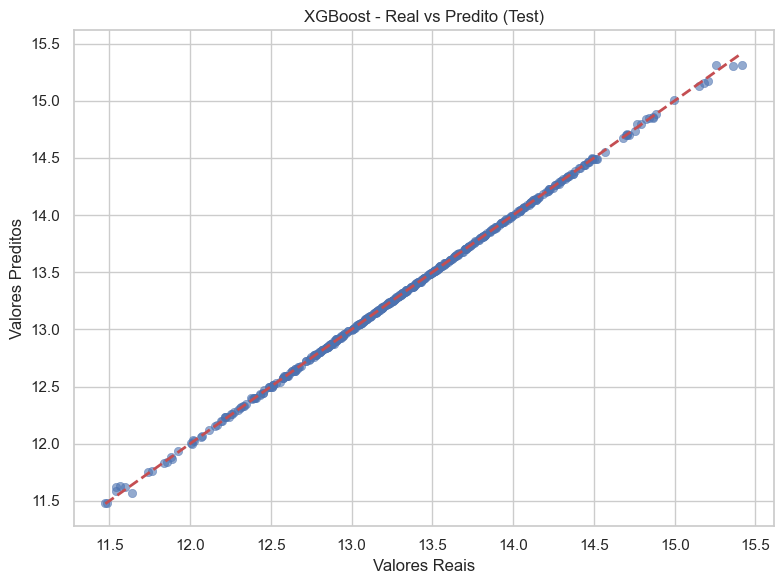

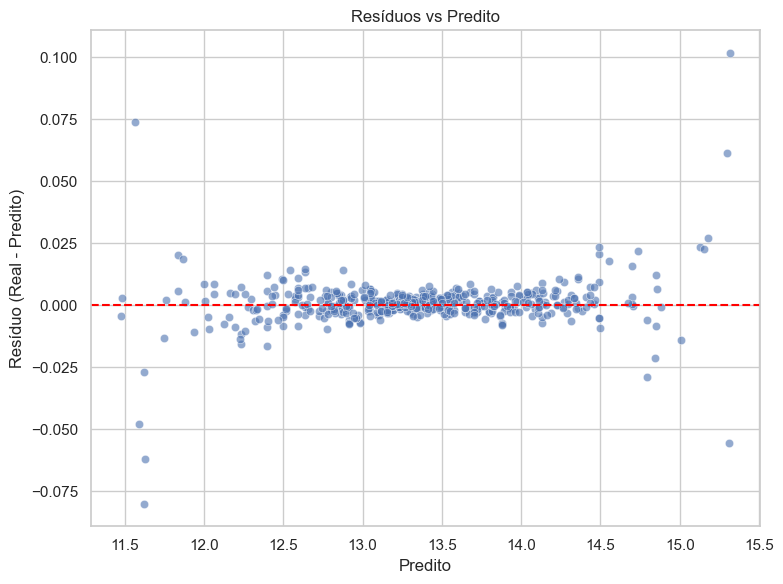

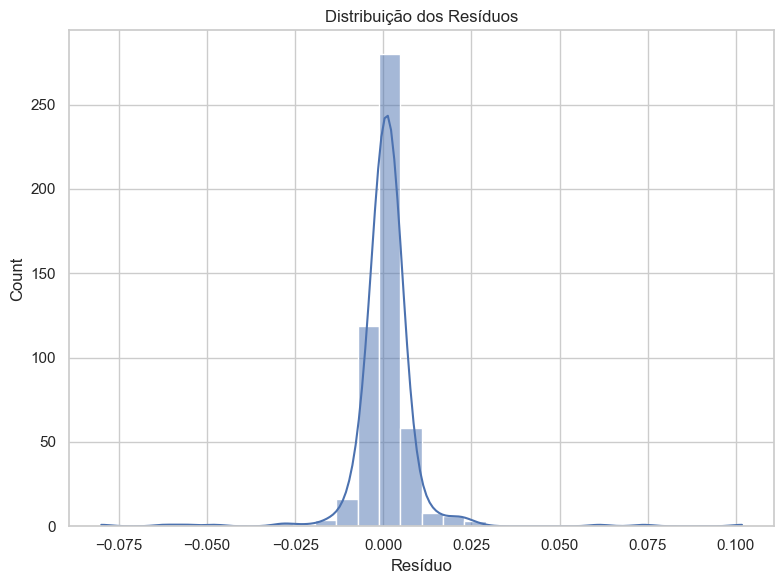


Top 10 piores previsões (Test):


,real,predito,erro_abs
203,15.417522,15.315774,0.101748
116,11.542251,11.622266,0.080015
363,11.640597,11.566714,0.073883
389,11.567281,11.629333,0.062051
103,15.360525,15.299212,0.061313
381,15.252783,15.308467,0.055684
55,11.543018,11.590885,0.047867
192,14.766210,14.795336,0.029126
368,15.203066,15.175963,0.027103
185,11.597487,11.624435,0.026948


✓ Top 10 piores previsões salvo em models/top10_piores_previsoes.csv


In [38]:
# CÉLULA 16 - Gráficos finais: Predito vs Real, Resíduos, Piores erros
# ---------------------------------------------------------
# 1) Predito vs Real
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6, edgecolor=None)
minv = min(y_test.min(), np.min(y_test_pred))
maxv = max(y_test.max(), np.max(y_test_pred))
plt.plot([minv, maxv],[minv, maxv], 'r--', lw=2)
plt.xlabel("Valores Reais")
plt.ylabel("Valores Preditos")
plt.title(f"{best_name} - Real vs Predito (Test)")
plt.grid(True)
plt.tight_layout()
plt.savefig("models/predito_vs_real_etapa4.png", dpi=200)
plt.show()

# 2) Resíduos vs Predito
residuos = y_test - y_test_pred
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_pred, y=residuos, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predito")
plt.ylabel("Resíduo (Real - Predito)")
plt.title("Resíduos vs Predito")
plt.grid(True)
plt.tight_layout()
plt.savefig("models/residuos_vs_predito_etapa4.png", dpi=200)
plt.show()

# 3) Distribuição dos resíduos
plt.figure(figsize=(8,6))
sns.histplot(residuos, bins=30, kde=True)
plt.xlabel("Resíduo")
plt.title("Distribuição dos Resíduos")
plt.grid(True)
plt.tight_layout()
plt.savefig("models/distribuicao_residuos_etapa4.png", dpi=200)
plt.show()

# 4) Piores previsões (maiores erros absolutos)
resultados = pd.DataFrame({
    "real": y_test.values,
    "predito": y_test_pred
})
resultados["erro_abs"] = np.abs(resultados["real"] - resultados["predito"])
piores = resultados.nlargest(10, "erro_abs")
print("\nTop 10 piores previsões (Test):")
display(piores)
piores.to_csv("models/top10_piores_previsoes.csv", index=False)
print("✓ Top 10 piores previsões salvo em models/top10_piores_previsoes.csv")
